# Project: Predict Bike Sharing Demand with AutoGluon


This notebook is the result of my work on the project **Predict Bike Sharing Demand with AutoGluon** for the course **Introduction to Machine Learning** of **AWS Machine Learning Engineer Nanodegree** from Udacity.

The aim is to train, test, and optimize an AutoGluon Tabular prediction model using kaggle bike sharing demand dataset.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
![kaggle1.png](attachment:kaggle1.png)
![kaggle2.png](attachment:kaggle2.png)
2. Scroll down to API and click Create New API Token.
![kaggle3.png](attachment:kaggle3.png)
![kaggle4.png](attachment:kaggle4.png)
3. Open up `kaggle.json` and use the username and key.
![kaggle5.png](attachment:kaggle5.png)

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-21.3.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
  Using cached wheel-0.37.0-py2.py3-none-any.whl (35 kB)
  Using cached mxnet-1.8.0.post0-py2.py3-none-manylinux2014_x86_64.whl (46.9 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.0
    Uninstalling bokeh-2.4.0:
      Successfully uninstalled bokeh-2.4.0
     |████████████████████████████████| 352 kB 19.7 MB/s            
     |████████████████████████████████| 56 kB 53.4 MB/s            
     |████████████████████████████████| 273 kB 67.0 MB/s            
     |████████████████████████████████| 52 kB 39.3 MB/s            
     |████████████████████████████████| 1.0 MB 64.7 MB/s            
     |████████████████████████████████| 4.2 MB 59.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "franciscadossantos"
kaggle_key = "9ea039d355dccc12185d4f7db37a6147"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 2.47MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", index_col=0, parse_dates=['datetime'])
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", index_col=0, parse_dates=['datetime'])
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", index_col=0, parse_dates=['datetime'])
submission.head()

,count
datetime,
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0
2011-01-20 03:00:00,0
2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train[train.columns.difference(['casual', 'registered'])],
    #train_data=train.drop(columns=['casual', 'registered']) 
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211119_084804/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211119_084804/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 8
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3094.92 MB
	Train Data (Original)  Memory Usage: 0.7 MB (0.0% of available memory)
	Inferring data type of each feature based on column val

[1000]	train_set's rmse: 136.821	valid_set's rmse: 154.06


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 138.493	valid_set's rmse: 140.701


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 137.12	valid_set's rmse: 152.914


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 138.4	valid_set's rmse: 144.757
[2000]	train_set's rmse: 134.49	valid_set's rmse: 143.86
[3000]	train_set's rmse: 131.912	valid_set's rmse: 143.67


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 137.407	valid_set's rmse: 149.891


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 137.606	valid_set's rmse: 146.13


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 138.716	valid_set's rmse: 138.723


	-145.5912	 = Validation score   (root_mean_squared_error)
	19.99s	 = Training   runtime
	0.91s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 375.32s of the 575.33s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' arg

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -139.422186       4.919205  503.563932                0.002894           0.436826            3       True         19
1     ExtraTreesMSE_BAG_L2 -140.046740       4.507138  381.811252                0.462520           5.945038            2       True         16
2        LightGBMXT_BAG_L2 -140.884772       4.171416  383.355045                0.126798           7.488830            2       True         12
3   NeuralNetFastAI_BAG_L2 -141.061377       4.376056  484.276273                0.331438         108.410058            2       True         17
4          CatBoost_BAG_L2 -141.122948       4.078937  400.783198                0.034319          24.916984            2       True         15
5      WeightedEnsemble_L2 -141.469332       3.214550  365.971019         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGB

<AxesSubplot:xlabel='model'>

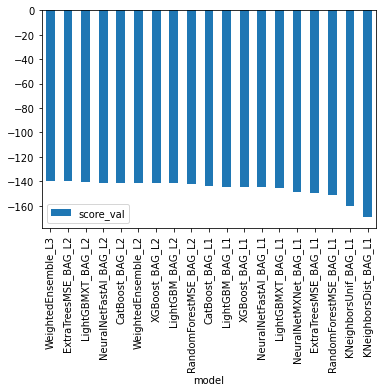

In [ ]:
predictor.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions.head()

datetime
2011-01-20 00:00:00    119.032722
2011-01-20 01:00:00     77.490082
2011-01-20 02:00:00     77.490082
2011-01-20 03:00:00     85.609558
2011-01-20 04:00:00     85.609558
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      192.393265
std       110.803368
min        17.270805
25%       105.699173
50%       166.954834
75%       266.450897
max       633.914795
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
#predictions.shape
print('number of negative values in predictions:', sum(predictions<0))

number of negative values in predictions: 0


In [ ]:
# Set them to zero
if (sum(predictions<0)>0):
    predictions[predictions<0]=0

### Set predictions to submission dataframe, save, and submit

In [ ]:
#submission["count"] = predictions
#submission.to_csv("submission.csv", index=True)
predictions.to_csv("submission.csv", index=True)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 456kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2021-11-19 09:08:05  first raw submission  complete  1.32554      1.32554       


#### Initial score of '1.32554'

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

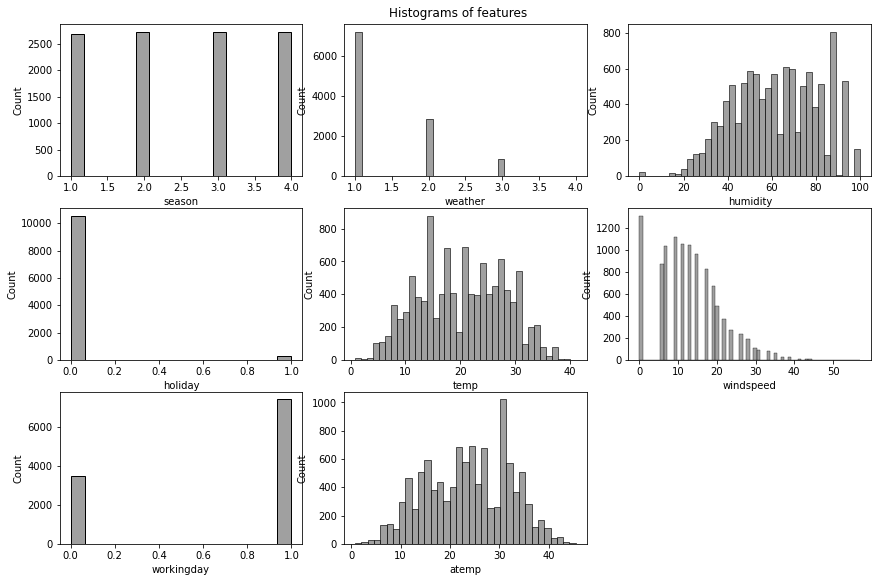

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis

#train[train.columns[0:8]].hist()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
fig.suptitle('Histograms of features')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
    
for i, col in enumerate(train.columns[0:3]):
    sns.histplot(data = train[train.columns[0:8]], x = col, ax = ax[i,0], color='gray')
    ax[i,0].set_xlabel(col)

for i, col in enumerate(train.columns[3:6]):
    sns.histplot(data = train[train.columns[0:8]], x = col, ax = ax[i,1], color='gray')
    ax[i,1].set_xlabel(col)
    
for i, col in enumerate(train.columns[6:8]):
    sns.histplot(data = train[train.columns[0:8]], x = col, ax = ax[i,2], color='gray')
    ax[i,2].set_xlabel(col)

ax[2,2].set_axis_off()

plt.show()
#clear the plot and figure
plt.clf()
plt.close()


In [ ]:
# create a new feature
train['hour'] = train.index.hour
test['hour'] = test.index.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [ ]:
print(train.dtypes)
#print(test.dtypes)

season        category
holiday          int64
workingday       int64
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
hour             int64
dtype: object


In [ ]:
# View the new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


['windspeed', 'atemp', 'humidity', 'holiday', 'workingday', 'temp']


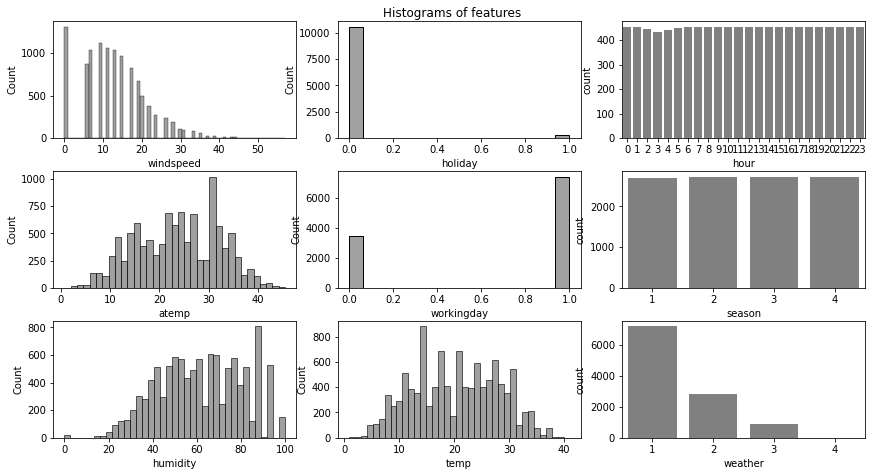

In [ ]:
# View histogram of all features again now with the hour feature

#train.drop(columns=['casual', 'registered', 'count']).hist()
#train['hour'].hist()

cat_features = ['hour', 'season', 'weather']
all_features = train.columns.difference(['casual', 'registered', 'count'])
features = list(set(all_features).difference(set(cat_features)))
print(features)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 6.5))
fig.suptitle('Histograms of features')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
    
for i, col in enumerate(features[0:3]):
    sns.histplot(data = train, x = col, ax = ax[i,0], color='gray')
    ax[i,0].set_xlabel(col)

for i, col in enumerate(features[3:6]):
    sns.histplot(data = train, x = col, ax = ax[i,1], color='gray')
    ax[i,1].set_xlabel(col)

# countplot ("histogram") of categorical variables
for i, col in enumerate(cat_features[0:3]):
    sns.countplot(data = train, x = col, ax = ax[i,2], color='gray')
    ax[i,2].set_xlabel(col)

plt.show()
#clear the plot and figure
plt.clf()
plt.close()

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train[train.columns.difference(['casual', 'registered'])],
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211119_134441/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211119_134441/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3046.91 MB
	Train Data (Original)  Memory Usage: 0.63 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

[1000]	train_set's rmse: 56.8491	valid_set's rmse: 64.496
[2000]	train_set's rmse: 51.7203	valid_set's rmse: 63.1298
[3000]	train_set's rmse: 48.5131	valid_set's rmse: 62.8427


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.203	valid_set's rmse: 69.6238
[2000]	train_set's rmse: 51.9426	valid_set's rmse: 67.4092
[3000]	train_set's rmse: 48.7808	valid_set's rmse: 66.7905
[4000]	train_set's rmse: 46.4734	valid_set's rmse: 66.6053
[5000]	train_set's rmse: 44.5611	valid_set's rmse: 66.5007
[6000]	train_set's rmse: 42.9874	valid_set's rmse: 66.6658


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.3969	valid_set's rmse: 63.7721
[2000]	train_set's rmse: 52.0874	valid_set's rmse: 63.2885


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 56.6267	valid_set's rmse: 70.4558
[2000]	train_set's rmse: 51.4134	valid_set's rmse: 69.0847
[3000]	train_set's rmse: 48.2922	valid_set's rmse: 68.7587
[4000]	train_set's rmse: 45.9858	valid_set's rmse: 68.4752
[5000]	train_set's rmse: 44.0702	valid_set's rmse: 68.4069


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.3128	valid_set's rmse: 63.2779
[2000]	train_set's rmse: 52.1248	valid_set's rmse: 62.4305
[3000]	train_set's rmse: 49.0133	valid_set's rmse: 62.2787
[4000]	train_set's rmse: 46.659	valid_set's rmse: 62.1244


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 56.9514	valid_set's rmse: 67.8053
[2000]	train_set's rmse: 51.6248	valid_set's rmse: 66.7414
[3000]	train_set's rmse: 48.3632	valid_set's rmse: 66.5894


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.2659	valid_set's rmse: 65.4625
[2000]	train_set's rmse: 51.9343	valid_set's rmse: 63.9294
[3000]	train_set's rmse: 48.7487	valid_set's rmse: 63.6677


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.0179	valid_set's rmse: 65.7365
[2000]	train_set's rmse: 51.9045	valid_set's rmse: 64.7696


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 56.8682	valid_set's rmse: 66.9728
[2000]	train_set's rmse: 51.6216	valid_set's rmse: 66.4988


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 57.7314	valid_set's rmse: 61.4474
[2000]	train_set's rmse: 52.4543	valid_set's rmse: 60.251
[3000]	train_set's rmse: 49.2708	valid_set's rmse: 60.2388


	-64.4709	 = Validation score   (root_mean_squared_error)
	49.23s	 = Training   runtime
	2.65s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 340.9s of the 540.94s of remaining time.
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 42.7431	valid_set's rmse: 63.3428


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 43.3231	valid_set's rmse: 66.3818


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 42.6176	valid_set's rmse: 70.0987
[2000]	train_set's rmse: 34.6878	valid_set's rmse: 69.6571


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 43.3566	valid_set's rmse: 63.2974


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 42.5812	valid_set's rmse: 69.2606


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 42.399	valid_set's rmse: 67.0798


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 43.2465	valid_set's rmse: 67.5135


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-65.4947	 = Validation score   (root_mean_squared_error)
	16.16s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 321.57s of the 521.61s of remaining time.
	-69.4801	 = Validation score   (root_mean_squared_error)
	5.98s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 312.64s of the 512.68s of remaining time.
	-65.3305	 = Validation score   (root_mean_squared_error)
	148.1s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 163.57s of the 363.61s of remai

[1000]	train_set's rmse: 22.2751	valid_set's rmse: 70.4049


	Ran out of time, early stopping on iteration 1175. Best iteration is:
	[1174]	train_set's rmse: 20.1317	valid_set's rmse: 70.33
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[1000]	train_set's rmse: 22.4501	valid_set's rmse: 62.4932


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-65.7226	 = Validation score   (root_mean_squared_error)
	26.22s	 = Training   runtime
	0.6s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 204.64s of remaining time.
	-63.431	 = Validation score   (root_mean_squared_e

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -62.823046       6.437877  501.959774                0.000732           0.384999            3       True         20
1   NeuralNetFastAI_BAG_L2  -63.162845       5.911405  466.522003                0.336735         102.002436            2       True         17
2      WeightedEnsemble_L2  -63.431036       4.537538  356.013238                0.000761           0.468076            2       True         11
3          CatBoost_BAG_L2  -63.634552       5.633571  393.522890                0.058901          29.003323            2       True         15
4     ExtraTreesMSE_BAG_L2  -63.693343       6.041509  370.569016                0.466839           6.049449            2       True         16
5        LightGBMXT_BAG_L2  -64.059619       5.700703  371.586722         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Ligh

In [ ]:
# nicely print the leaderboard
predictor_new_features.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-62.823046,6.437877,501.959774,0.000732,0.384999,3,True,20
1,NeuralNetFastAI_BAG_L2,-63.162845,5.911405,466.522003,0.336735,102.002436,2,True,17
2,WeightedEnsemble_L2,-63.431036,4.537538,356.013238,0.000761,0.468076,2,True,11
3,CatBoost_BAG_L2,-63.634552,5.633571,393.522890,0.058901,29.003323,2,True,15
4,ExtraTreesMSE_BAG_L2,-63.693343,6.041509,370.569016,0.466839,6.049449,2,True,16
5,LightGBMXT_BAG_L2,-64.059619,5.700703,371.586722,0.126033,7.067154,2,True,12
6,LightGBM_BAG_L2,-64.131776,5.655279,370.696517,0.080609,6.176950,2,True,13
7,XGBoost_BAG_L2,-64.336221,5.683565,376.290873,0.108895,11.771305,2,True,18
8,RandomForestMSE_BAG_L2,-64.416950,6.034707,389.500851,0.460037,24.981283,2,True,14
9,LightGBMXT_BAG_L1,-64.470922,2.649480,49.227980,2.649480,49.227980,1,True,3


<AxesSubplot:xlabel='model'>

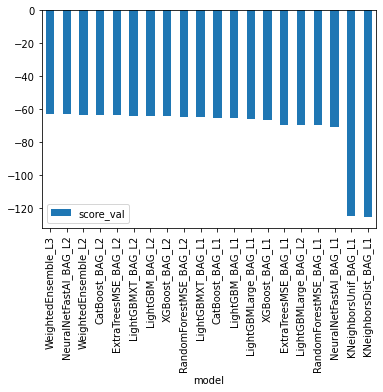

In [ ]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
# Remember to set all negative values to zero
predictions = predictor_new_features.predict(test)
predictions.head(25)

datetime
2011-01-20 00:00:00     17.389666
2011-01-20 01:00:00      8.881134
2011-01-20 02:00:00      5.772181
2011-01-20 03:00:00      5.032150
2011-01-20 04:00:00      5.392416
2011-01-20 05:00:00     19.925163
2011-01-20 06:00:00     60.115376
2011-01-20 07:00:00    154.075790
2011-01-20 08:00:00    349.448914
2011-01-20 09:00:00    178.136505
2011-01-20 10:00:00     96.653763
2011-01-20 11:00:00    106.801514
2011-01-20 12:00:00    137.059906
2011-01-20 13:00:00    122.207489
2011-01-20 14:00:00    114.429291
2011-01-20 15:00:00    119.011803
2011-01-20 16:00:00    128.291473
2011-01-20 17:00:00    251.595383
2011-01-20 18:00:00    219.789505
2011-01-20 19:00:00    156.084457
2011-01-20 20:00:00    104.509048
2011-01-20 21:00:00     74.467255
2011-01-20 22:00:00     53.489647
2011-01-20 23:00:00     38.830025
2011-01-21 00:00:00     19.744217
Name: count, dtype: float32

In [ ]:
#print the number of negatives values in prediction and set then all to 0
print('number of negative values in predictions:', sum(predictions<0))
if (sum(predictions<0)>0):
    predictions[predictions<0]=0
print('number of negative values in predictions:', sum(predictions<0))

number of negative values in predictions: 0
number of negative values in predictions: 0


In [ ]:
# Same submitting predictions
#submission_new_features["count"] = ?
#submission_new_features.to_csv("submission_new_features.csv", index=False)

predictions.to_csv("submission_new_features.csv", index=True)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 666kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2021-11-19 14:01:29  new features          complete  0.48859      0.48859       
submission.csv               2021-11-19 09:08:05  first raw submission  complete  1.32554      1.32554       


#### New Score of `0.48859`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
###---------------------------------------------------------1°----------------------------------------------------------###

In [ ]:
# 1° configuration of hyperparameters: num_bag_sets=30

#define hyperparameter and hyperparameter_tune_kwargs
import autogluon.core as ag

# possible model keys are the following:
# to include in 'hyperparameters' of .fit() only the keys to the models you would like to train
#‘GBM’ (LightGBM)
#‘CAT’ (CatBoost)
#‘XGB’ (XGBoost)
#‘RF’ (random forest)
#‘XT’ (extremely randomized trees)
#‘KNN’ (k-nearest neighbors)
#‘LR’ (linear regression)
#‘NN’ (neural network with MXNet backend)
#‘FASTAI’ (neural network with FastAI backend)
#'custom'"""

hyperparameters1 = {
    'GBM': {},
    'RF':{},
    'CAT':{},
    'XT':{},
    'XGB':{},
    'FASTAI':{},
    'NN': {},
    'KNN':{},
    'LR':{},
    'custom':{}
}

time_limit = 600 # time limit to train the models
num_trials = 10  # number of hyperparameter combinations to try for each type of model
search_strategy = 'random' # search strategy for HPO, ‘random’ by default

hyperparameter_tune_kwargs1 = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials':num_trials,
    'scheduler' :'local',
    'searcher':search_strategy
}


In [ ]:
# training with the 1° hyperparameters configuration

predictor_new_hpo1 = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']),
    excluded_model_types=['LR', 'custom'],
    time_limit=time_limit,
    presets='best_quality',
    keep_only_best=True,
    num_bag_folds=10, #values between 5-10 are recommend to maximize predictive performance (<=10 to avoid overfitting)
    num_bag_sets=30, #Defaults to 1 if time_limit is not specified, otherwise 20. Note: increase it to further improve predictions
    hyperparameters=hyperparameters1,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs1
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211121_164912/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211121_164912/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3092.94 MB
	Train Data (Original)  Memory Usage: 0.63 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

In [ ]:
predictor_new_hpo1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -66.491492       3.260489  461.457073                0.000845           0.191516            3       True          8
1       ExtraTrees_BAG_L2/T0  -66.892220       2.410931  343.516861                0.455672           4.641700            2       True          6
2  NeuralNetFastAI_BAG_L2/T0  -67.596603       2.274666  441.970144                0.319407         103.094982            2       True          7
3     RandomForest_BAG_L2/T0  -67.738540       2.484564  353.528875                0.529305          14.653713            2       True          5
4       ExtraTrees_BAG_L1/T0  -69.046042       0.417550    3.141624                0.417550           3.141624            1       True          3
5     RandomForest_BAG_L1/T0  -69.480780       0.422858    6.0

{'model_types': {'KNeighbors_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'RandomForest_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'RandomForest_BAG_L2/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighbors_BAG_L1/T0': -124.6932607515444,
  'RandomForest_BAG_L1/T0': -69.48078035696645,
  'ExtraTrees_BAG_L1/T0': -69.04604249238437,
  'NeuralNetFastAI_BAG_L1/T0': -71.09899959450614,
  'RandomForest_BAG_L2/T0': -67.7385398219722,
  'ExtraTrees_BAG_L2/T0': -66.89221977064628,
  'NeuralNetFastAI_BAG_L2/T0': -67.59660344869935,
  'WeightedEnsemble_L3': -66.49149248727382},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighbors_BAG_L1/T0': 'AutogluonModels/ag-20211121_164912/model

In [ ]:
# nicely print the leaderboard
predictor_new_hpo1.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-66.491492,3.260489,461.457073,0.000845,0.191516,3,True,8
1,ExtraTrees_BAG_L2/T0,-66.892220,2.410931,343.516861,0.455672,4.641700,2,True,6
2,NeuralNetFastAI_BAG_L2/T0,-67.596603,2.274666,441.970144,0.319407,103.094982,2,True,7
3,RandomForest_BAG_L2/T0,-67.738540,2.484564,353.528875,0.529305,14.653713,2,True,5
4,ExtraTrees_BAG_L1/T0,-69.046042,0.417550,3.141624,0.417550,3.141624,1,True,3
5,RandomForest_BAG_L1/T0,-69.480780,0.422858,6.085605,0.422858,6.085605,1,True,2
6,NeuralNetFastAI_BAG_L1/T0,-71.099000,0.907600,329.615118,0.907600,329.615118,1,True,4
7,KNeighbors_BAG_L1/T0,-124.693261,0.207251,0.032814,0.207251,0.032814,1,True,1


<AxesSubplot:xlabel='model'>

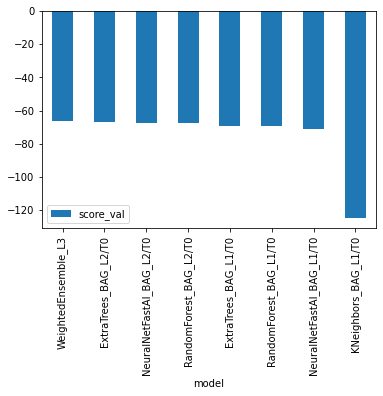

In [ ]:
# plot leaderborad
predictor_new_hpo1.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
# make predictions
# Remember to set all negative values to zero
predictions = predictor_new_hpo1.predict(test)
predictions.head(25)

datetime
2011-01-20 00:00:00     11.437170
2011-01-20 01:00:00      6.837480
2011-01-20 02:00:00      3.670739
2011-01-20 03:00:00      2.775363
2011-01-20 04:00:00      3.133798
2011-01-20 05:00:00     16.383648
2011-01-20 06:00:00     61.763676
2011-01-20 07:00:00    172.774017
2011-01-20 08:00:00    325.222198
2011-01-20 09:00:00    176.992325
2011-01-20 10:00:00     94.441841
2011-01-20 11:00:00    111.241806
2011-01-20 12:00:00    124.644714
2011-01-20 13:00:00    119.260803
2011-01-20 14:00:00    132.187439
2011-01-20 15:00:00    137.121613
2011-01-20 16:00:00    136.423950
2011-01-20 17:00:00    235.876572
2011-01-20 18:00:00    216.859222
2011-01-20 19:00:00    165.945877
2011-01-20 20:00:00    113.731369
2011-01-20 21:00:00     71.262398
2011-01-20 22:00:00     54.160915
2011-01-20 23:00:00     35.615326
2011-01-21 00:00:00     14.200090
Name: count, dtype: float32

In [ ]:
#print the number of negatives values in prediction and set then to 0
print('number of negative values in predictions:', sum(predictions<0))
if (sum(predictions<0) > 0):
    predictions[predictions<0]=0
print('number of negative values in predictions: (zero)', sum(predictions<0))

number of negative values in predictions: 2
number of negative values in predictions: (zero) 0


In [ ]:
# Same submitting predictions
#submission_new_hpo["count"] = ?
#submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

predictions.to_csv("submission_new_hpo.csv", index=True)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 556kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2021-11-21 17:05:48  new features with hyperparameters  complete  0.46097      0.46097       
submission_new_features.csv  2021-11-19 14:01:29  new features                       complete  0.48859      0.48859       
submission.csv               2021-11-19 09:08:05  first raw submission               complete  1.32554      1.32554       


#### New Score of `0.46097`

## Step 6.1: Testing a 2° configuration of HPO

In [ ]:
###---------------------------------------------------------2°----------------------------------------------------------###

In [ ]:
#### 2° configuration of hyperparameters: to exclude k-nearest neighbors mmodels

import autogluon.core as ag

hyperparameters2 = {
    'GBM': {},
    'RF':{},
    'CAT':{},
    'XT':{},
    'XGB':{},
    'FASTAI':{},
    'NN': {},
    'KNN':{},
    'LR':{},
    'custom':{}
}

time_limit = 600 # time limit to train the models
num_trials = 10  # number of different hyperparameter configurations to try for each type of model
search_strategy = 'random' # search strategy for HPO, ‘random’ by default

hyperparameter_tune_kwargs2 = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials':num_trials,
    'scheduler' :'local',
    'searcher':search_strategy
}

In [ ]:
# training with the 2° set of hyperparameters

predictor_new_hpo2 = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']),
    excluded_model_types=['KNN', 'LR', 'custom'], #excluding KNN
    time_limit=time_limit,
    presets='best_quality',
    keep_only_best=True,
    num_bag_folds=10, #values between 5-10 are recommend to maximize predictive performance (<=10 to avoid overfitting)
    num_bag_sets=30, #Defaults to 1 if time_limit is not specified, otherwise 20. Note: increase it to further improve predictions
    use_bag_holdout=True,
    hyperparameters=hyperparameters2,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211122_103530/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20211122_103530/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2462.45 MB
	Train Data (Original)  Memory Usage: 0.63 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

In [ ]:
predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3 -67.599540       2.544724  447.302845                0.000618           0.135785            3       True          6
1  NeuralNetFastAI_BAG_L2/T0 -67.820973       2.145627  443.624824                0.562897         172.958070            2       True          5
2       ExtraTrees_BAG_L2/T0 -68.453377       1.981209  274.208990                0.398479           3.542236            2       True          4
3       ExtraTrees_BAG_L1/T0 -69.656488       0.387986    2.538814                0.387986           2.538814            1       True          2
4     RandomForest_BAG_L1/T0 -71.287284       0.391246    4.945891                0.391246           4.945891            1       True          1
5  NeuralNetFastAI_BAG_L1/T0 -72.547448       0.803498  263.182049  

{'model_types': {'RandomForest_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'ExtraTrees_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForest_BAG_L1/T0': -71.28728427424558,
  'ExtraTrees_BAG_L1/T0': -69.65648809883434,
  'NeuralNetFastAI_BAG_L1/T0': -72.54744818543755,
  'ExtraTrees_BAG_L2/T0': -68.4533768643661,
  'NeuralNetFastAI_BAG_L2/T0': -67.82097310823146,
  'WeightedEnsemble_L3': -67.5995404587003},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'RandomForest_BAG_L1/T0': 'AutogluonModels/ag-20211122_103530/models/RandomForest_BAG_L1/T0/',
  'ExtraTrees_BAG_L1/T0': 'AutogluonModels/ag-20211122_103530/models/ExtraTrees_BAG_L1/T0/',
  'NeuralNetFastAI_BAG_L1/T0': 'AutogluonModels/ag-20211122_103530/models/NeuralN

In [ ]:
# nicely print the leaderboard
predictor_new_hpo2.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-67.599540,2.544724,447.302845,0.000618,0.135785,3,True,6
1,NeuralNetFastAI_BAG_L2/T0,-67.820973,2.145627,443.624824,0.562897,172.958070,2,True,5
2,ExtraTrees_BAG_L2/T0,-68.453377,1.981209,274.208990,0.398479,3.542236,2,True,4
3,ExtraTrees_BAG_L1/T0,-69.656488,0.387986,2.538814,0.387986,2.538814,1,True,2
4,RandomForest_BAG_L1/T0,-71.287284,0.391246,4.945891,0.391246,4.945891,1,True,1
5,NeuralNetFastAI_BAG_L1/T0,-72.547448,0.803498,263.182049,0.803498,263.182049,1,True,3


<AxesSubplot:xlabel='model'>

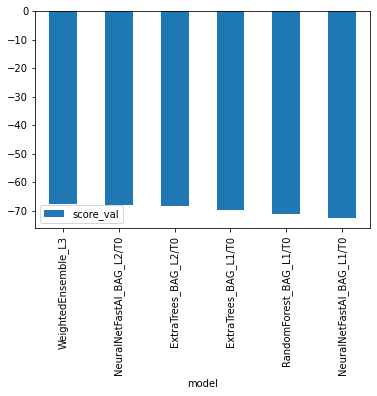

In [ ]:
predictor_new_hpo2.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
# make predictions
predictions = predictor_new_hpo2.predict(test)
predictions.head()

datetime
2011-01-20 00:00:00    11.985916
2011-01-20 01:00:00     7.744028
2011-01-20 02:00:00     6.231426
2011-01-20 03:00:00     4.198833
2011-01-20 04:00:00     4.397983
Name: count, dtype: float32

In [ ]:
#print the number of negatives values in prediction and set then to 0
print('number of negative values in predictions:', sum(predictions<0))
if (sum(predictions<0) > 0):
    predictions[predictions<0]=0
print('number of negative values in predictions (zero):', sum(predictions<0))

number of negative values in predictions: 12
number of negative values in predictions (zero): 0


In [ ]:
#send predictions to submission file
predictions.to_csv("submission_new_hpo_2.csv", index=True)

In [ ]:
#submit predictions to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_2.csv -m "new features with hyperparameters -- 2° config"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 618kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                                     status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission_new_hpo_2.csv     2021-11-22 09:42:29  new features with hyperparameters -- 2° config  complete  0.47688      0.47688       
submission_new_hpo.csv       2021-11-21 17:05:48  new features with hyperparameters               complete  0.46097      0.46097       
submission_new_features.csv  2021-11-19 14:01:29  new features                                    complete  0.48859      0.48859       
submission.csv               2021-11-19 09:08:05  first raw submission                            complete  1.32554      1.32554       


#### New Score of `0.47688`

## Step 6.2: Testing a 3° configuration of HPO

In [ ]:
###---------------------------------------------------------3°----------------------------------------------------------###

In [ ]:
# 3° configuration of hyperparameters: num_bag_folds=6 and num_bag_sets=40 (.fit())

import autogluon.core as ag

hyperparameters3 = {
    'GBM': {},
    'RF':{},
    'CAT':{},
    'XT':{},
    'XGB':{},
    'FASTAI':{},
    'NN': {},
    'KNN':{},
    'LR':{},
    'custom':{}
}

time_limit = 1200 # time limit to train the models
num_trials = 10  # number of hyperparameter combinations to try for each type of model
search_strategy = 'random' # search strategy for HPO, ‘random’ by default

hyperparameter_tune_kwargs3 = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials':num_trials,
    'scheduler' :'local',
    'searcher':search_strategy
}

In [ ]:
predictor_new_hpo3 = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']),
    excluded_model_types=['LR', 'custom'],
    time_limit=time_limit,
    presets='best_quality',
    keep_only_best=True,
    num_bag_folds=6, #Increase in training time. oss. values between 5-10 are recommend to maximize predictive performance (<=10 to avoid overfitting)
    num_bag_sets=40, #Defaults to 1 if time_limit is not specified, otherwise 20. Note: increase it to further improve predictions
    hyperparameters=hyperparameters3,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs3
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211122_171002/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20211122_171002/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2472.48 MB
	Train Data (Original)  Memory Usage: 0.63 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

In [ ]:
predictor_new_hpo3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -66.212467       5.952295  1081.514348                0.000864           0.204592            3       True          8
1       ExtraTrees_BAG_L2/T0  -66.624093       4.143926   722.872378                0.468664           4.767822            2       True          6
2  NeuralNetFastAI_BAG_L2/T0  -66.931165       5.006044  1061.784339                1.330781         343.679782            2       True          7
3     RandomForest_BAG_L2/T0  -67.523648       4.151987   732.862152                0.476724          14.757596            2       True          5
4       ExtraTrees_BAG_L1/T0  -69.046042       0.430598     3.159736                0.430598           3.159736            1       True          3
5     RandomForest_BAG_L1/T0  -69.480780       0.427206 

{'model_types': {'KNeighbors_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'RandomForest_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'RandomForest_BAG_L2/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighbors_BAG_L1/T0': -124.6932607515444,
  'RandomForest_BAG_L1/T0': -69.48078035696645,
  'ExtraTrees_BAG_L1/T0': -69.04604249238437,
  'NeuralNetFastAI_BAG_L1/T0': -70.65135111543417,
  'RandomForest_BAG_L2/T0': -67.52364803636407,
  'ExtraTrees_BAG_L2/T0': -66.62409321980864,
  'NeuralNetFastAI_BAG_L2/T0': -66.93116529683968,
  'WeightedEnsemble_L3': -66.21246729792344},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighbors_BAG_L1/T0': 'AutogluonModels/ag-20211122_171002/mode

In [ ]:
# nicely print the leaderboard
predictor_new_hpo3.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-66.212467,5.952295,1081.514348,0.000864,0.204592,3,True,8
1,ExtraTrees_BAG_L2/T0,-66.624093,4.143926,722.872378,0.468664,4.767822,2,True,6
2,NeuralNetFastAI_BAG_L2/T0,-66.931165,5.006044,1061.784339,1.330781,343.679782,2,True,7
3,RandomForest_BAG_L2/T0,-67.523648,4.151987,732.862152,0.476724,14.757596,2,True,5
4,ExtraTrees_BAG_L1/T0,-69.046042,0.430598,3.159736,0.430598,3.159736,1,True,3
5,RandomForest_BAG_L1/T0,-69.480780,0.427206,6.139306,0.427206,6.139306,1,True,2
6,NeuralNetFastAI_BAG_L1/T0,-70.651351,2.612178,708.770314,2.612178,708.770314,1,True,4
7,KNeighbors_BAG_L1/T0,-124.693261,0.205281,0.035201,0.205281,0.035201,1,True,1


<AxesSubplot:xlabel='model'>

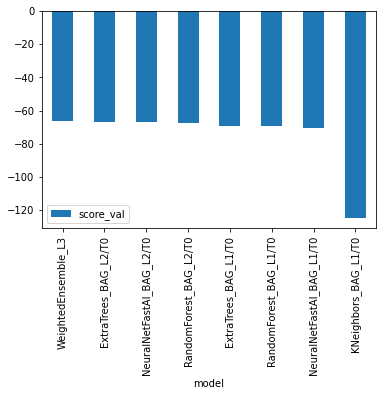

In [ ]:
# plot leaderborad
predictor_new_hpo3.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
# make predictions
predictions = predictor_new_hpo3.predict(test)
predictions.head(25)

datetime
2011-01-20 00:00:00     12.286291
2011-01-20 01:00:00      8.333618
2011-01-20 02:00:00      4.028082
2011-01-20 03:00:00      2.681695
2011-01-20 04:00:00      3.039511
2011-01-20 05:00:00     15.698542
2011-01-20 06:00:00     61.798584
2011-01-20 07:00:00    167.873749
2011-01-20 08:00:00    339.350555
2011-01-20 09:00:00    186.346542
2011-01-20 10:00:00     94.961838
2011-01-20 11:00:00    114.666031
2011-01-20 12:00:00    128.140884
2011-01-20 13:00:00    115.977768
2011-01-20 14:00:00    126.977417
2011-01-20 15:00:00    135.217636
2011-01-20 16:00:00    135.757828
2011-01-20 17:00:00    238.777039
2011-01-20 18:00:00    216.372284
2011-01-20 19:00:00    165.825165
2011-01-20 20:00:00    110.512100
2011-01-20 21:00:00     70.076920
2011-01-20 22:00:00     53.682487
2011-01-20 23:00:00     33.847134
2011-01-21 00:00:00     13.252724
Name: count, dtype: float32

In [ ]:
#print the number of negatives values in prediction and set then to 0
print('number of negative values in predictions:', sum(predictions<0))
if (sum(predictions<0) > 0):
    predictions[predictions<0]=0
print('number of negative values in predictions: (zero)', sum(predictions<0))

number of negative values in predictions: 2
number of negative values in predictions: (zero) 0


In [ ]:
predictions.to_csv("submission_new_hpo_3.csv", index=True)

In [ ]:
#submit predictions to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_3.csv -m "new features with hyperparameters -- 3° config"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 591kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                                     status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission_new_hpo_3.csv     2021-11-22 18:22:11  new features with hyperparameters -- 3° config  complete  0.46169      0.46169       
submission_new_hpo_4.csv     2021-11-22 18:16:41  new features with hyperparameters -- 4° config  complete  0.46152      0.46152       
submission_new_hpo_2.csv     2021-11-22 17:37:13  new features with hyperparameters -- 3° config  complete  0.47163      0.47163       
submission_new_hpo_2.csv     2021-11-22 09:42:29  new features with hyperparameters -- 2° config  complete  0.47688      0.47688       


#### New Score of `0.46169`

## Step 6.3: Testing a 4° configuration of HPO

In [ ]:
###---------------------------------------------------------4°----------------------------------------------------------###

In [ ]:
# 4° configuration of hyperparameters: num_bag_folds=6 and num_bag_sets=40 (.fit());
#'max_stack_level':3, 'max_base_models':25, and 'max_base_models_per_type':5

#import autogluon.core as ag

hyperparameters4 = {
    'GBM': {},
    'RF':{},
    'CAT':{},
    'XT':{},
    'XGB':{},
    'FASTAI':{},
    'NN': {},
    'KNN':{},
    'LR':{},
    'custom':{}
}

time_limit = 1200 # time limit to train the models
num_trials = 10  # number of hyperparameter combinations to try for each type of model
search_strategy = 'random' # search strategy for HPO, ‘random’ by default

hyperparameter_tune_kwargs4 = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials':num_trials,
    'scheduler' :'local',
    'searcher':search_strategy,
    'max_stack_level':3, ###****as in new_feature simulation
    'max_base_models':25, ###****as in new_feature simulation
    'max_base_models_per_type':5 ###****as in new_feature simulation
}

In [ ]:
predictor_new_hpo4 = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(
    train_data=train.drop(columns=['casual', 'registered']),
    excluded_model_types=['LR', 'custom'],
    time_limit=time_limit,
    presets='best_quality',
    keep_only_best=True,
    num_bag_folds=6, #Increase in training time. oss. values between 5-10 are recommend to maximize predictive performance (<=10 to avoid overfitting)
    num_bag_sets=40, #Defaults to 1 if time_limit is not specified, otherwise 20. Note: increase it to further improve predictions
    hyperparameters=hyperparameters4,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs4
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211122_174912/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20211122_174912/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2370.25 MB
	Train Data (Original)  Memory Usage: 0.63 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

In [ ]:
predictor_new_hpo4.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -66.123600       5.672847  1104.473470                0.000727           0.189945            3       True          7
1       ExtraTrees_BAG_L2/T0  -66.489128       4.045884   695.317509                0.467010           4.792027            2       True          5
2  NeuralNetFastAI_BAG_L2/T0  -66.845501       5.205111  1099.491498                1.626236         408.966016            2       True          6
3       ExtraTrees_BAG_L1/T0  -69.046042       0.428499     3.051869                0.428499           3.051869            1       True          3
4     RandomForest_BAG_L1/T0  -69.480780       0.423294     6.143761                0.423294           6.143761            1       True          2
5  NeuralNetFastAI_BAG_L1/T0  -70.542723       2.522234 

{'model_types': {'KNeighbors_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'RandomForest_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'ExtraTrees_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighbors_BAG_L1/T0': -124.6932607515444,
  'RandomForest_BAG_L1/T0': -69.48078035696645,
  'ExtraTrees_BAG_L1/T0': -69.04604249238437,
  'NeuralNetFastAI_BAG_L1/T0': -70.54272300158196,
  'ExtraTrees_BAG_L2/T0': -66.48912795005472,
  'NeuralNetFastAI_BAG_L2/T0': -66.8455005646009,
  'WeightedEnsemble_L3': -66.12359957740448},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighbors_BAG_L1/T0': 'AutogluonModels/ag-20211122_174912/models/KNeighbors_BAG_L1/T0/',
  'RandomForest_BAG_L1/T0': 'AutogluonModels/ag-20211122_174912/models/Random

In [ ]:
# nicely print the leaderboard
predictor_new_hpo4.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-66.123600,5.672847,1104.473470,0.000727,0.189945,3,True,7
1,ExtraTrees_BAG_L2/T0,-66.489128,4.045884,695.317509,0.467010,4.792027,2,True,5
2,NeuralNetFastAI_BAG_L2/T0,-66.845501,5.205111,1099.491498,1.626236,408.966016,2,True,6
3,ExtraTrees_BAG_L1/T0,-69.046042,0.428499,3.051869,0.428499,3.051869,1,True,3
4,RandomForest_BAG_L1/T0,-69.480780,0.423294,6.143761,0.423294,6.143761,1,True,2
5,NeuralNetFastAI_BAG_L1/T0,-70.542723,2.522234,681.292799,2.522234,681.292799,1,True,4
6,KNeighbors_BAG_L1/T0,-124.693261,0.204847,0.037053,0.204847,0.037053,1,True,1


<AxesSubplot:xlabel='model'>

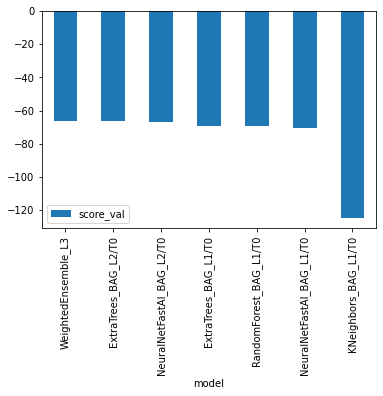

In [ ]:
# plot leaderborad
predictor_new_hpo4.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [ ]:
# make predictions
predictions = predictor_new_hpo4.predict(test)
predictions.head(25)

datetime
2011-01-20 00:00:00     13.192804
2011-01-20 01:00:00      8.449201
2011-01-20 02:00:00      4.663775
2011-01-20 03:00:00      3.206603
2011-01-20 04:00:00      3.669071
2011-01-20 05:00:00     16.087061
2011-01-20 06:00:00     61.313721
2011-01-20 07:00:00    164.042114
2011-01-20 08:00:00    331.530457
2011-01-20 09:00:00    182.239716
2011-01-20 10:00:00     95.308716
2011-01-20 11:00:00    110.786591
2011-01-20 12:00:00    125.118668
2011-01-20 13:00:00    119.798607
2011-01-20 14:00:00    129.153030
2011-01-20 15:00:00    134.758469
2011-01-20 16:00:00    136.790665
2011-01-20 17:00:00    243.578293
2011-01-20 18:00:00    211.940979
2011-01-20 19:00:00    167.190765
2011-01-20 20:00:00    112.091370
2011-01-20 21:00:00     72.569183
2011-01-20 22:00:00     58.369564
2011-01-20 23:00:00     35.005421
2011-01-21 00:00:00     14.968853
Name: count, dtype: float32

In [ ]:
#print the number of negatives values in prediction and set then to 0
print('number of negative values in predictions:', sum(predictions<0))
if (sum(predictions<0) > 0):
    predictions[predictions<0]=0
print('number of negative values in predictions: (zero)', sum(predictions<0))

number of negative values in predictions: 1
number of negative values in predictions: (zero) 0


In [ ]:
predictions.to_csv("submission_new_hpo_4.csv", index=True)

In [ ]:
#submit predictions to kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_4.csv -m "new features with hyperparameters -- 4° config"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 613kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                                     status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------------  --------  -----------  ------------  
submission_new_hpo_4.csv     2021-11-22 18:16:41  new features with hyperparameters -- 4° config  complete  0.46152      0.46152       
submission_new_hpo_2.csv     2021-11-22 17:37:13  new features with hyperparameters -- 3° config  complete  0.47163      0.47163       
submission_new_hpo_2.csv     2021-11-22 09:42:29  new features with hyperparameters -- 2° config  complete  0.47688      0.47688       
submission_new_hpo.csv       2021-11-21 17:05:48  new features with hyperparameters               complete  0.46097      0.46097       


#### New Score of `0.46152`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

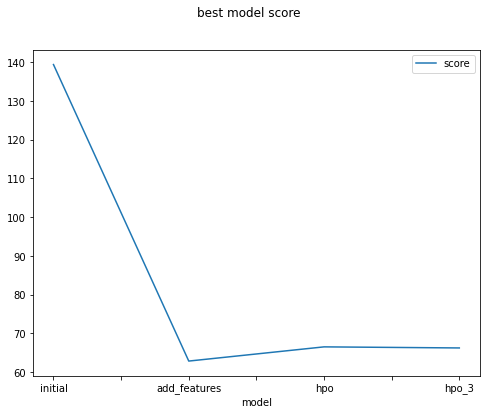

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
#import pandas as pd
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpo_3"],
        "score": [139.422186, 62.823046, 66.491492, 66.212467]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.suptitle('best model score')
fig.savefig('model_train_score_python.png')

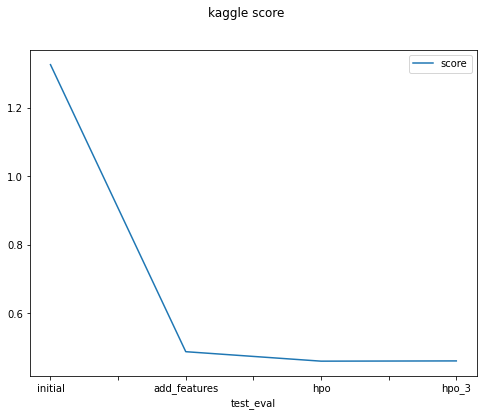

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hpo_3"],
        "score": [1.32554, 0.48859, 0.46097, 0.46169]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.suptitle('kaggle score')
fig.savefig('model_test_score_python.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo", "hpo_3"],
    "time_limit": [600, 600, 600, 1200],
    "num_bag_sets": [20, 20, 30, 40],
    "num_bag_folds": [10, 10, 10, 6],
    "score": [1.32554, 0.48859, 0.46097, 0.46169]
})

,model,time_limit,num_bag_sets,num_bag_folds,score
0,initial,600,20,10,1.32554
1,add_features,600,20,10,0.48859
2,hpo,600,30,10,0.46097
3,hpo_3,1200,40,6,0.46169
